In [1]:
!pip install transformers
!pip install xlrd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 690.0 kB/s eta 0:00:00


In [2]:
!nvidia-smi

Thu Oct 20 02:30:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import xlrd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertConfig, BertTokenizer, RobertaModel, RobertaConfig, RobertaTokenizer,AdamW, get_cosine_schedule_with_warmup

class Bert(nn.Module):
    def __init__(self, bert_path, classes=2):
        super(Bert, self).__init__()
        self.config = BertConfig.from_pretrained(bert_path)
        self.bert = BertModel.from_pretrained(bert_path)
        self.fc = nn.Linear(self.config.hidden_size, classes)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask, token_type_ids)
        out = outputs[1]
        out = self.fc(out)
        return logit
    
class Roberta(nn.Module):
    def __init__(self, roberta_path, classes=2):
        super(Roberta, self).__init__()
        self.config = RobertaConfig.from_pretrained(roberta_path)
        self.roberta = RobertaModel.from_pretrained(roberta_path)
        self.fc = nn.Linear(self.config.hidden_size, classes)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.roberta(input_ids, attention_mask)
        out = outputs[1]
        out = self.fc(out)
        return out


def get_parameter_number(model):
    #  打印模型参数
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel()
                        for p in model.parameters() if p.requires_grad)
    return 'Total parameters: {}, Trainable parameters: {}'.format(total_num, trainable_num)

def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, (ids, att, y) in (enumerate(data_loader)):
            total += y.shape[0]

            y_pred = model(ids.to(device), att.to(device))
            y_pred = torch.argmax(y_pred, dim=1).detach().cpu()
            y = torch.argmax(y, dim=1).detach().cpu()
            correct += torch.sum(y_pred==y)

    return correct/total


def train_and_eval(model, train_loader, valid_loader,
                   optimizer, scheduler, device, epoch):
    best_acc = 0.0
    patience = 0
    criterion = nn.CrossEntropyLoss()
    losses = []
    accs = []
    begin = time.time()
    for i in range(epoch):
        start = time.time()
        model.train()
        print("***** Running training epoch {} *****".format(i+1))
        train_loss_sum = 0.0
        for idx, (ids, att, y) in enumerate(train_loader):
            ids, att, y = ids.to(device), att.to(device), y.to(device)
            y_pred = model(ids, att)
            loss = criterion(y_pred, y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss_sum += loss.item()
            if (idx + 1) % (len(train_loader)//5) == 0:
                print("Epoch {:04d} | Step {:04d}/{:04d} | Loss {:.4f} | Time {:.4f}".format(
                    i+1, idx+1, len(train_loader), train_loss_sum/(idx+1), time.time() - start))
                # print("Learning rate = {}".format(optimizer.state_dict()['param_groups'][0]['lr']))

        losses.append(train_loss_sum/(idx+1))
        
        acc = evaluate(model, valid_loader, device)
        accs.append(acc)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(),
                       "../checkpoint/best_roberta_model.pth")

        print("current acc is {:.4f}, best acc is {:.4f}".format(
            acc, best_acc))
        print("time costed = {}s \n".format(round(time.time() - start, 5)))
        
    np.save("loss.npy", np.array(losses))
    np.save("accuracy.npy", np.array(accs))
    
    print("Total time costed = {}s \n".format(round(time.time() - begin, 5)))


In [4]:
roberta_path = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(roberta_path)

data_path = {"train": "../data/Constraint_English_Train.xls",
             "val": "../data/Constraint_English_Val.xls", "test": "../data/english_test_with_labels.xls"}
dataset = {"train": None, "val": None, "test": None}

length=0
for key, path in data_path.items():
    input_ids = []
    attention_mask = []
    label = []

    excel = xlrd.open_workbook(path)
    sheet = excel.sheet_by_index(0)
    column_rows = sheet.nrows

    for row in range(1, column_rows):
        data = sheet.row_values(row)
        length=length if length>=len(data[1]) else len(data[1])
        encode_dict = (tokenizer.encode_plus(
            data[1], max_length=140, padding='max_length', truncation=True))

        input_ids.append(encode_dict['input_ids'])
        attention_mask.append(encode_dict['attention_mask'])

        if data[2] == "real":
            label.append([0,1])
        else:
            label.append([1,0])

    input_ids = torch.LongTensor(input_ids)
    attention_mask = torch.LongTensor(attention_mask)
    label = torch.LongTensor(label)

    dataset[key] = [input_ids, attention_mask, label]


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [5]:
BATCH_SIZE = 32

train_data = TensorDataset(dataset["train"][0],
                           dataset["train"][1],
                           dataset["train"][2])
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=BATCH_SIZE)

val_data = TensorDataset(dataset["val"][0],
                         dataset["val"][1],
                         dataset["val"][2])
val_loader = DataLoader(
    val_data, shuffle=False, batch_size=BATCH_SIZE)

test_data = TensorDataset(dataset["test"][0],
                          dataset["test"][1],
                          dataset["test"][2])
test_loader = DataLoader(
    test_data, shuffle=False, batch_size=BATCH_SIZE)

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 15

model = Roberta(roberta_path).to(DEVICE)
print(get_parameter_number(model))

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_loader),
                                            num_training_steps=EPOCHS*len(train_loader))

train_and_eval(model, train_loader, val_loader,
               optimizer, scheduler, DEVICE, EPOCHS)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Total parameters: 124647170, Trainable parameters: 124647170
***** Running training epoch 1 *****


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch 0001 | Step 0040/0201 | Loss 0.6949 | Time 17.1381
Epoch 0001 | Step 0080/0201 | Loss 0.6822 | Time 33.2276
Epoch 0001 | Step 0120/0201 | Loss 0.6205 | Time 49.2997
Epoch 0001 | Step 0160/0201 | Loss 0.5173 | Time 65.4015
Epoch 0001 | Step 0200/0201 | Loss 0.4437 | Time 81.4899
current acc is 0.9285, best acc is 0.9285
time costed = 91.23403s 

***** Running training epoch 2 *****
Epoch 0002 | Step 0040/0201 | Loss 0.1139 | Time 16.0607
Epoch 0002 | Step 0080/0201 | Loss 0.1097 | Time 32.3419
Epoch 0002 | Step 0120/0201 | Loss 0.1081 | Time 48.3961
Epoch 0002 | Step 0160/0201 | Loss 0.1004 | Time 64.5025
Epoch 0002 | Step 0200/0201 | Loss 0.0938 | Time 80.5752
current acc is 0.9654, best acc is 0.9654
time costed = 90.58467s 

***** Running training epoch 3 *****
Epoch 0003 | Step 0040/0201 | Loss 0.0399 | Time 16.0808
Epoch 0003 | Step 0080/0201 | Loss 0.0480 | Time 32.1887
Epoch 0003 | Step 0120/0201 | Loss 0.0455 | Time 48.2546
Epoch 0003 | Step 0160/0201 | Loss 0.0512 | Time 

In [7]:
model.load_state_dict(torch.load("../checkpoint/best_roberta_model.pth"))
acc = evaluate(model, test_loader, DEVICE)
print(acc)


tensor(0.9780)


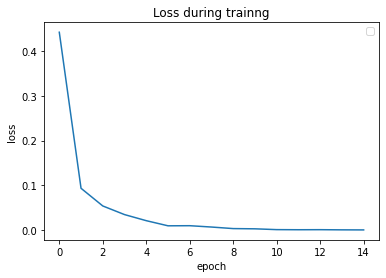

In [8]:
losses = np.load("loss.npy")

plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses)
plt.title('Loss during trainng')
plt.legend()
plt.show()

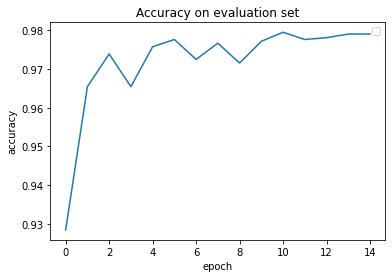

In [9]:
accs = np.load("accuracy.npy")

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(accs)
plt.title('Accuracy on evaluation set')
plt.legend()
plt.show()